
=== Example recommendations for job index 0 ===
job_title                                               data scientist
company_size_group                                               large
salary_max                                                    200938.0
skills_clean          spark|r|python|scala|machine learning|tensorflow
Name: 0, dtype: object
     job_title company_size_group  salary_max  similarity
data scientist              large    200934.0    0.984204
data scientist              large    197284.0    0.983649
data scientist              large    183991.0    0.977853
data scientist              large    164400.0    0.975021
data scientist              large    213719.0    0.971664
data scientist              large    215273.0    0.971245
data scientist              large    165590.0    0.959162
data scientist              large    261214.0    0.947043
data scientist              large    263104.0    0.944944
data scientist              large    263106.0    0.944942
data s

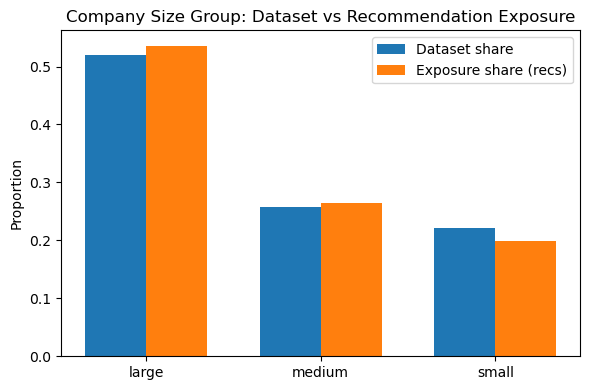


=== Index-Based Exposure Bias Summary ===
company_size_group  dataset_share  exposure_share  exposure_ratio
             small       0.221622           0.152        0.685854
            medium       0.258378           0.130        0.503138
             large       0.520000           0.718        1.380769


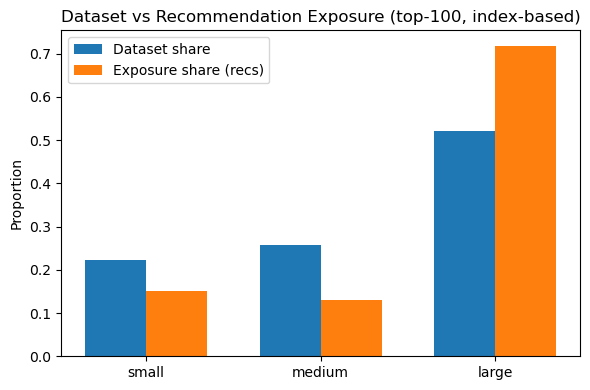

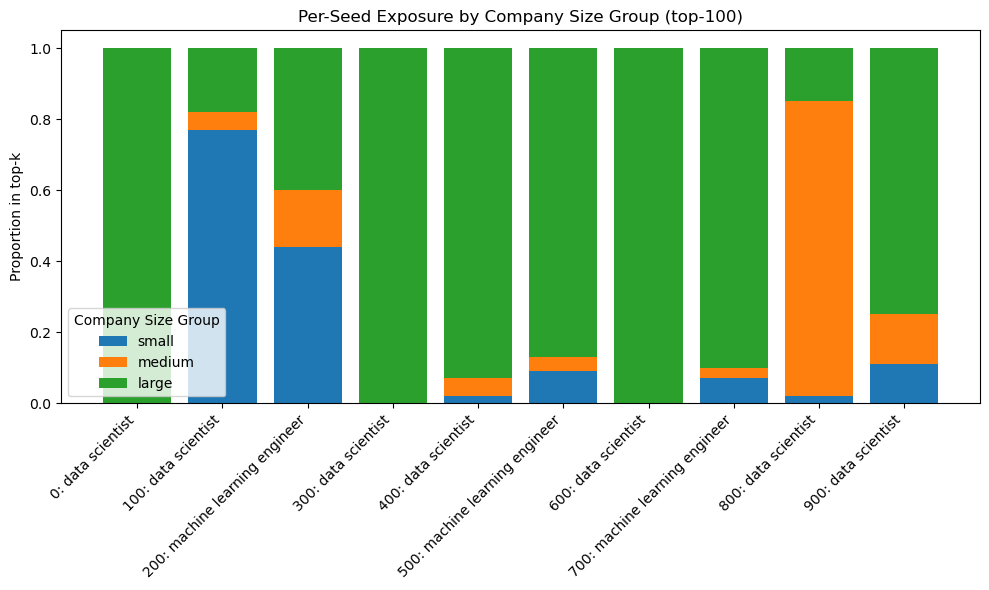

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# Load embeddings and metadata
df, X_hybrid = joblib.load("../data/hybrid_embeddings.pkl")

# Similar job recommendations
def recommend_similar_jobs(job_index, top_k=20):
    """
    Recommend top_k jobs similar to the job at job_index,
    based on cosine similarity over X_hybrid.
    """
    query_vec = X_hybrid[job_index]
    sims = cosine_similarity(query_vec, X_hybrid).flatten()

    ranked_idx = np.argsort(-sims)
    ranked_idx = ranked_idx[ranked_idx != job_index]

    top_idx = ranked_idx[:top_k]
    top_sims = sims[top_idx]

    results = df.iloc[top_idx].copy()
    results["similarity"] = top_sims

    return results


# Quick check
print("\n=== Example recommendations for job index 0 ===")
print(df.iloc[0][["job_title", "company_size_group", "salary_max", "skills_clean"]])
print(
    recommend_similar_jobs(0, top_k=20)[
        ["job_title", "company_size_group", "salary_max", "similarity"]
    ].to_string(index=False)
)


# Exposure bias measurement (random seeds)
def measure_exposure_bias(num_seeds=300, top_k=20, random_state=42):
    rng = np.random.default_rng(random_state)
    n = len(df)

    valid_df = df[df["company_size_group"] != "unknown"].copy()
    dataset_counts = valid_df["company_size_group"].value_counts().sort_index()
    dataset_share = dataset_counts / dataset_counts.sum()

    seed_indices = rng.integers(0, n, size=num_seeds)

    exposure_counts = {}

    for idx in seed_indices:
        recs = recommend_similar_jobs(idx, top_k=top_k)
        recs_valid = recs[recs["company_size_group"] != "unknown"]

        counts = recs_valid["company_size_group"].value_counts()
        for group, c in counts.items():
            exposure_counts[group] = exposure_counts.get(group, 0) + c

    exposure_series = pd.Series(exposure_counts).sort_index()
    total_recs = exposure_series.sum()
    exposure_share = exposure_series / total_recs

    groups = sorted(dataset_share.index)
    rows = []
    for g in groups:
        ds = float(dataset_share.get(g, 0.0))
        es = float(exposure_share.get(g, 0.0))
        ratio = es / ds if ds > 0 else np.nan
        rows.append({
            "company_size_group": g,
            "dataset_share": ds,
            "exposure_share": es,
            "exposure_ratio": ratio,
        })

    summary = pd.DataFrame(rows)

    print(f"\n=== Exposure Bias Summary (num_seeds={num_seeds}, top_k={top_k}) ===")
    print(summary.to_string(index=False))

    x = np.arange(len(summary))
    width = 0.35

    plt.figure(figsize=(6, 4))
    plt.bar(x - width/2, summary["dataset_share"], width, label="Dataset share")
    plt.bar(x + width/2, summary["exposure_share"], width, label="Exposure share (recs)")

    plt.xticks(x, summary["company_size_group"])
    plt.ylabel("Proportion")
    plt.title("Company Size Group: Dataset vs Recommendation Exposure")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return summary


bias_summary = measure_exposure_bias(num_seeds=300, top_k=20)


# Exposure bias measurement for specific indices
def measure_exposure_bias_job_indices(indices, top_k=20):
    """
    Measure exposure bias using index-based job recommendations.
    """

    df_valid = df[df["company_size_group"] != "unknown"].copy()
    dataset_counts = df_valid["company_size_group"].value_counts().sort_index()
    dataset_share = dataset_counts / dataset_counts.sum()

    exposure_counts = {}
    per_seed_exposure = []

    groups = ["small", "medium", "large"]

    for idx in indices:
        recs = recommend_similar_jobs(idx, top_k=top_k)
        recs_valid = recs[recs["company_size_group"] != "unknown"].copy()

        counts = recs_valid["company_size_group"].value_counts()
        exposure_counts_for_seed = {
            "seed_index": idx,
            "seed_title": str(df.iloc[idx]["job_title"]) if "job_title" in df.columns else f"job_{idx}",
            "small": counts.get("small", 0),
            "medium": counts.get("medium", 0),
            "large": counts.get("large", 0),
        }
        per_seed_exposure.append(exposure_counts_for_seed)

        for group, c in counts.items():
            exposure_counts[group] = exposure_counts.get(group, 0) + c

    exposure_series = pd.Series(exposure_counts).sort_index()
    total_recs = exposure_series.sum()
    exposure_share = exposure_series / total_recs

    rows = []
    for g in groups:
        ds = float(dataset_share.get(g, 0.0))
        es = float(exposure_share.get(g, 0.0))
        ratio = es / ds if ds > 0 else np.nan
        rows.append({
            "company_size_group": g,
            "dataset_share": ds,
            "exposure_share": es,
            "exposure_ratio": ratio,
        })

    summary = pd.DataFrame(rows)

    print("\n=== Index-Based Exposure Bias Summary ===")
    print(summary.to_string(index=False))

    x = np.arange(len(summary))
    width = 0.35

    plt.figure(figsize=(6, 4))
    plt.bar(x - width/2, summary["dataset_share"], width, label="Dataset share")
    plt.bar(x + width/2, summary["exposure_share"], width, label="Exposure share (recs)")

    plt.xticks(x, summary["company_size_group"])
    plt.ylabel("Proportion")
    plt.title(f"Dataset vs Recommendation Exposure (top-{top_k}, index-based)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    per_seed_df = pd.DataFrame(per_seed_exposure)
    per_seed_df["total"] = per_seed_df[["small", "medium", "large"]].sum(axis=1)
    for g in groups:
        per_seed_df[g + "_share"] = np.where(
            per_seed_df["total"] > 0,
            per_seed_df[g] / per_seed_df["total"],
            0.0,
        )

    per_seed_df["seed_label"] = (
        per_seed_df["seed_index"].astype(str)
        + ": "
        + per_seed_df["seed_title"].str.slice(0, 25)
        + np.where(per_seed_df["seed_title"].str.len() > 25, "...", "")
    )

    plt.figure(figsize=(10, 6))
    bottom = np.zeros(len(per_seed_df))
    color_map = {"small": "tab:blue", "medium": "tab:orange", "large": "tab:green"}

    for g in groups:
        plt.bar(
            per_seed_df["seed_label"],
            per_seed_df[g + "_share"],
            bottom=bottom,
            label=g,
            color=color_map[g],
        )
        bottom += per_seed_df[g + "_share"].values

    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Proportion in top-k")
    plt.title(f"Per-Seed Exposure by Company Size Group (top-{top_k})")
    plt.legend(title="Company Size Group")
    plt.tight_layout()
    plt.show()

    return summary, per_seed_df


seed_indices = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]

bias_summary_index, per_seed_detail = measure_exposure_bias_job_indices(
    indices=seed_indices,
    top_k=100,
)